In [1]:
from __future__ import division
import os
os.sys.path.append("/home/izmailovpavel/Documents/Projects/pristine-ml/")

from oil.lazy.lazy_matrix import LazyMatrix, Lazy
from oil.lazy.lazy_types import LazyAvg
from oil.utils.utils import reusable
from oil.lazy.linalg.VRmethods import GradLoader, oja_grad2,SGHA_grad2,SGD,SVRG, SGHA_grad,oja_subspace_grad
from oil.logging.lazyLogger import LazyLogger

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import time
import pandas as pd

## Network import

In [3]:
import numpy as np
import torch
import sys
sys.path.append("/home/izmailovpavel/Documents/Projects/mode-geometry/")
# from models import VGG16
# from torchvision.datasets import CIFAR100
import torch.nn.functional as F
# import tqdm
# import data
import data_noaug
import models
import utils
# import understanding_utils
# from understanding_utils import UnderstandingNetwork
# from torch.autograd import Variable

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
path = "/home/izmailovpavel/datasets/cifar100/"
loaders, num_classes = data_noaug.loaders(
    "CIFAR10",
    "/home/izmailovpavel/datasets/",
    128,
    4,
    "VGG",
    True
)
# loaders["train"] = reusable(loaders["train"])
# loaders["test"] = reusable(loaders["test"])

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


In [5]:
torch.backends.cudnn.benchmark = True
num_classes = 10
criterion = F.cross_entropy

In [6]:
architecture = getattr(models, "SmallConvFC")

model = architecture.base(num_classes=num_classes, **architecture.kwargs)
model.cuda()
checkpoint = torch.load("/home/izmailovpavel/Documents/ckpts/c10/smallconvfc/run1/checkpoint-200.pt")
# checkpoint = torch.load("/home/izmailovpavel/Documents/ckpts/c10/smallconvfc/run2/checkpoint-200.pt")
model.load_state_dict(checkpoint['model_state'])
# checkpoint = torch.load("/home/izmailovpavel/Documents/ckpts/c10/smallconvfc/run6/checkpoint-300.pt")
# model.load_state_dict(checkpoint['swa_state'])

model.device = next(model.parameters()).device
model.eval()

print(utils.test(loaders["test"], model, criterion))

{'accuracy': 84.84, 'loss': 0.4700113704681396, 'nll': 0.4700113704681396}


## Hessian

In [7]:
from oil.lazy.hessian import Hessian, Fisher

In [8]:
lazy_H = Hessian(model, loaders["train"], loss=criterion)

In [9]:
v = torch.ones([134122]).cuda()

In [10]:
lazy_H @ v

tensor([ 1.6278,  0.3642, -1.2045,  ...,  0.8824, -0.0901, -0.6819], device='cuda:0')

In [11]:
for h in lazy_H:
    break

In [12]:
h @ v

tensor([ 1.9909, -0.4636, -3.8205,  ...,  3.1634,  1.0116,  0.9070], device='cuda:0')

## Power Method

In [30]:
w = torch.randn(lazy_H.shape[0]).cuda()
w /= torch.norm(w)

for i in range(100):
    w = lazy_H @ w
    print(torch.norm(w))
    w /= torch.norm(w)
    

tensor(0.2006, device='cuda:0')
tensor(18.8292, device='cuda:0')
tensor(21.5357, device='cuda:0')
tensor(22.5957, device='cuda:0')
tensor(23.3662, device='cuda:0')
tensor(23.9731, device='cuda:0')
tensor(24.5076, device='cuda:0')
tensor(24.8274, device='cuda:0')
tensor(25.0906, device='cuda:0')
tensor(25.2632, device='cuda:0')
tensor(25.3946, device='cuda:0')
tensor(25.4614, device='cuda:0')
tensor(25.5121, device='cuda:0')
tensor(25.5787, device='cuda:0')
tensor(25.5713, device='cuda:0')
tensor(25.5865, device='cuda:0')
tensor(25.5821, device='cuda:0')
tensor(25.5961, device='cuda:0')
tensor(25.5922, device='cuda:0')
tensor(25.5967, device='cuda:0')
tensor(25.5981, device='cuda:0')
tensor(25.5868, device='cuda:0')
tensor(25.6068, device='cuda:0')
tensor(25.5965, device='cuda:0')
tensor(25.5981, device='cuda:0')
tensor(25.6094, device='cuda:0')
tensor(25.5986, device='cuda:0')
tensor(25.6092, device='cuda:0')
tensor(25.6067, device='cuda:0')
tensor(25.6023, device='cuda:0')
tensor(25.5

## VR-PCA

In [13]:
# float_type = np.float64
lazy_H = Hessian(model, loaders["train"], loss=criterion)
grads = GradLoader(oja_grad2,[lazy_H])

In [14]:
# Setup code for logging
logger = LazyLogger(**{'no_print':True, 'minPeriod':0, 'timeFrac':1})
logger.i = 0 # annoying but we will add some temporary state to keep track of step
# sin_pair = lambda u, w: 1-((u@w)**2 /((w@w)*(u@u)))
def log(w, lr, grad):
    logger.i+=1
    with logger as do_log:
        if do_log:
            wallclocktime = time.time()
            metrics = {}
            metrics[r"$||\nabla L(w)||$"] = np.linalg.norm(grad)
            if (logger.i - 1) % 1000 == 0:
                metrics["Rayleigh Quotient"] = w @ (lazy_H @ w) / (w @ w)
                print(logger.i, ":", metrics["Rayleigh Quotient"])
            else:
                metrics["Rayleigh Quotient"] = 0
#             metrics[r"$|\sin^2\measuredangle(v,w)|$"] = sin_pair(w,V[:,0])
            logger.add_scalars('metrics', metrics, step=logger.i)

In [33]:
w0 = torch.randn(lazy_H.shape[0]).cuda()
w0 /= torch.norm(w0)
lr = lambda e: .01#*cosLr(num_epochs)(e)
num_epochs = 50#30
logger.scalar_frame=pd.DataFrame()
w = SVRG(grads,w0,lr,num_epochs,log)

1 : tensor(0.0061, device='cuda:0')
2001 : tensor(25.6246, device='cuda:0')
3001 : tensor(25.6083, device='cuda:0')
4001 : tensor(25.6073, device='cuda:0')
5001 : tensor(25.5936, device='cuda:0')
6001 : tensor(25.5972, device='cuda:0')
7001 : tensor(25.6026, device='cuda:0')
8001 : tensor(25.5998, device='cuda:0')
9001 : tensor(25.6040, device='cuda:0')
10001 : tensor(25.5967, device='cuda:0')
11001 : tensor(25.6141, device='cuda:0')
12001 : tensor(25.6028, device='cuda:0')
13001 : tensor(25.6048, device='cuda:0')
14001 : tensor(25.5972, device='cuda:0')
15001 : tensor(25.6003, device='cuda:0')
16001 : tensor(25.6021, device='cuda:0')
17001 : tensor(25.6010, device='cuda:0')
18001 : tensor(25.6016, device='cuda:0')
19001 : tensor(25.5947, device='cuda:0')


In [25]:
 logger.scalar_dict.keys()

dict_keys(['runs/Dec02_21-02-56_nepashka/metrics/$||\\nabla L(w)||$', 'runs/Dec02_21-02-56_nepashka/metrics/Rayleigh Quotient'])

NameError: name 'float_type' is not defined

<Figure size 432x288 with 0 Axes>

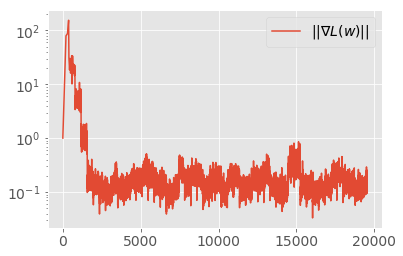

In [34]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})
f = plt.figure()
logger.scalar_frame.plot(logy=True)
plt.axhline(y=np.finfo(float_type).eps,label = r"Machine $\epsilon$",color='k')
plt.ylabel('Relative Error')
plt.xlabel("Iterations")
plt.legend()
f.savefig("VR_PCA.pdf", bbox_inches='tight')

In [27]:
w @ (lazy_H @ w) / (w @ w)

tensor(26.3018, device='cuda:0')

In [28]:
w @ w

tensor(26.0362, device='cuda:0')

## VR-GPCA

In [13]:
lazy_H = Hessian(model, loaders["train"], loss=criterion)
lazy_F = Fisher(model, loaders["train"])
grads = GradLoader(SGHA_grad,[lazy_H, lazy_F])

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fd2c63a8438>>
Traceback (most recent call last):
  File "/home/izmailovpavel/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/izmailovpavel/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/izmailovpavel/.local/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, a

In [14]:
# Setup code for logging
# logger = LazyLogger(**{'no_print':True, 'minPeriod':0, 'timeFrac':1})
logger = LazyLogger(**{'no_print':False, 'minPeriod':0, 'timeFrac':1})
logger.i = 0 # annoying but we will add some temporary state to keep track of step
def log(w,lr,grad):
    logger.i+=1
    with logger as do_log:
        if do_log:
            wallclocktime = time.time()
            metrics = {}
            metrics[r"$||\nabla L(w)||$"] = np.linalg.norm(grad)
            if (logger.i - 1) % 10 == 0:
                metrics["Rayleigh Quotient"] = w @ (lazy_H @ w) / (w @ (lazy_F @ w))
                print(logger.i, ":", metrics["Rayleigh Quotient"])
            else:
                metrics["Rayleigh Quotient"] = 0
            logger.add_scalars('metrics',metrics,step=logger.i)

In [16]:
w0 = torch.randn(lazy_H.shape[0]).cuda()
w0 /= torch.norm(w0)
lr = lambda e: .0025 if e < 65 else 0.001#*cosLr(num_epochs)(e)
num_epochs = 100
logger.scalar_frame=pd.DataFrame()
w = SVRG(grads,w0,lr,num_epochs,log)

Epoch  0
1 : tensor(1.0033, device='cuda:0')
Epoch  1
681 : tensor(1.0221, device='cuda:0')
Epoch  2
901 : tensor(1.0297, device='cuda:0')
1001 : tensor(1.0338, device='cuda:0')
1071 : tensor(1.0359, device='cuda:0')
Epoch  3
1271 : tensor(1.0458, device='cuda:0')
1351 : tensor(1.0491, device='cuda:0')
1381 : tensor(1.0506, device='cuda:0')
1511 : tensor(1.0574, device='cuda:0')
Epoch  4
1631 : tensor(1.0646, device='cuda:0')
Epoch  5
2161 : tensor(1.1014, device='cuda:0')
2191 : tensor(1.1026, device='cuda:0')
2321 : tensor(1.1143, device='cuda:0')
Epoch  6
2381 : tensor(1.1200, device='cuda:0')
2451 : tensor(1.1265, device='cuda:0')
Epoch  7
2971 : tensor(1.1921, device='cuda:0')
Epoch  8
3161 : tensor(1.2215, device='cuda:0')
Epoch  9
3841 : tensor(1.3639, device='cuda:0')
Epoch  10
3911 : tensor(1.3843, device='cuda:0')
3941 : tensor(1.3916, device='cuda:0')
Epoch  11
4331 : tensor(1.4949, device='cuda:0')
4361 : tensor(1.5044, device='cuda:0')
Epoch  12
4751 : tensor(1.6106, devic

NameError: name 'float_type' is not defined

<Figure size 432x288 with 0 Axes>

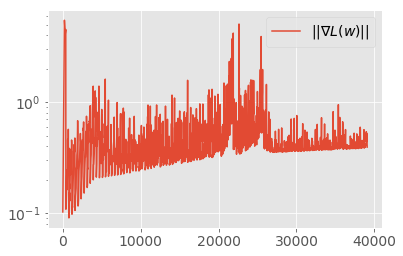

In [17]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})
f = plt.figure()
logger.scalar_frame.plot(logy=True)
plt.axhline(y=np.finfo(float_type).eps,label = r"Machine $\epsilon$",color='k')
plt.ylabel('Relative Error')
plt.xlabel("Iterations")
plt.legend()
f.savefig("VR_GPCA.pdf", bbox_inches='tight')

In [ ]:
len(logger.scalar_frame)

## Block VR-PCA (k=10)

In [31]:
n=10**5; rank = 100; float_type = np.float64
X,V,A_full = PCA_dataset(n,rank,float_type)
k = 10 # block size
# Create a Lazy Average from iterable of minibatches
A = LazyAvg(cov_gen(X))
grads = GradLoader(oja_subspace_grad,[A])

In [32]:
# Setup code for logging
logger = LazyLogger(**{'no_print':True, 'minPeriod':0, 'timeFrac':1})
logger.i = 0 # annoying but we will add some temporary state to keep track of step
VVT = V[:,:k]@V[:,:k].T
def log(W,lr,grad):
    logger.i+=1
    with logger as do_log:
        if do_log:
            wallclocktime = time.time()
            metrics = {}
            metrics[r"$||\nabla L(W)||_F$"] = np.linalg.norm(grad,ord='fro')
            metrics[r"$||VV^T - WW^T||_F$"] = np.linalg.norm(VVT - W@W.T,ord='fro')
            logger.add_scalars('metrics',metrics,step=logger.i)

In [33]:
W0 = np.random.randn(rank,k).astype(float_type)
W0, _ =  np.linalg.qr(W0) #orthogonalize the matrix
lr = lambda e: .1#*cosLr(num_epochs)(e)
num_epochs = 150
W = SVRG(grads,W0,lr,num_epochs,log)

<Figure size 432x288 with 0 Axes>

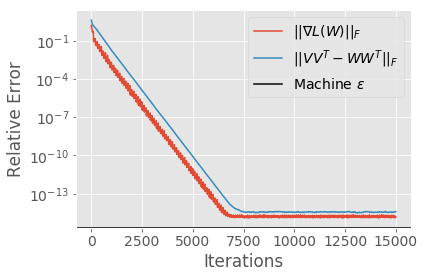

In [34]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})
f = plt.figure()
logger.scalar_frame.plot(logy=True)
plt.axhline(y=np.finfo(float_type).eps,label = r"Machine $\epsilon$",color='k')
plt.ylabel('Relative Error')
plt.xlabel("Iterations")
plt.legend()
f.savefig("VR_GPCA_subspace.pdf", bbox_inches='tight')

## Block VR-GPCA (k=10)

In [17]:
import numpy as np
import torch
np.random.rand(10,5).sqrt()

AttributeError: 'numpy.ndarray' object has no attribute 'sqrt'

In [25]:
torch.sqrt(torch.rand(10).cuda()@torch.rand(10).cuda())

tensor(1.2981, device='cuda:0')

In [15]:
torch.normal(10)

TypeError: normal(): argument 'mean' (position 1) must be Tensor, not int

In [20]:
np.sqrt(np.random.rand(10)@np.ones(10))

2.2786547960468644

In [27]:
for i in range(10):
    print(i)
    if i==2: break

0
1
2
